In [1]:
# Is an ARIMA(3,1,0) model suitable for the foot_traffic dataset ?

# Import time module
from datetime import datetime as dt

# Record start time
start = dt.now()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
# The dataset contains 1,000 data points of Average weekly foot traffic in a retail store, starting in the first 
# week of 2000. (Note that this is fictional data -> source: Time Series Forecasting in python by Marco Peixeiro)

df = pd.read_csv("data/foot_traffic.csv")
df.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


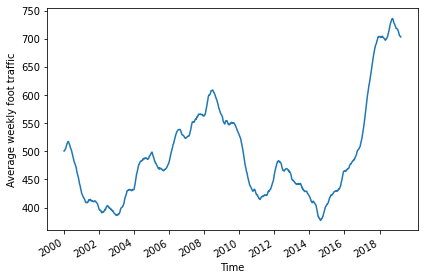

In [3]:
fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

# Tilt the labels on the x-axis ticks so that they display nicely
fig.autofmt_xdate()

plt.tight_layout()

In [4]:
# Test for stationerity using agugented Dickey Fuller algorithm

adf_result = adfuller(df)

print(f'ADF Statistic : {adf_result[0]}')
print(f'P-Value : {adf_result[1]}')

ADF Statistic : -1.175888599924078
P-Value : 0.6838808917896175


In [5]:
# The process is not statitionery, so we apply differentiation to make it stationery

df_diff = np.diff(df['foot_traffic'], n=1)

In [6]:
# Test again if the process is now stationery
adf_result = adfuller(df_diff)

print(f'ADF Statistic : {adf_result[0]}')
print(f'P-Value : {adf_result[1]}')

ADF Statistic : -5.2682313474220335
P-Value : 6.3693176547816065e-06


In [7]:
# We have a p-value smaller than 0.05 and a large negative ADF statistic, our series is stationary
# d = 1 (Number of rounds of differencing to make our data stationery)
d = 1

In [8]:
# Next we separate our data into train and test sets. 
# Evaluate performance of our forecast over a period of 1 year
# For model fitting, we will reserve 52 for test data and leave the rest for training data

train = df['foot_traffic'][:-50].copy()
test = df['foot_traffic'][-50:].copy()

print(len(train))
print(len(test))

950
50


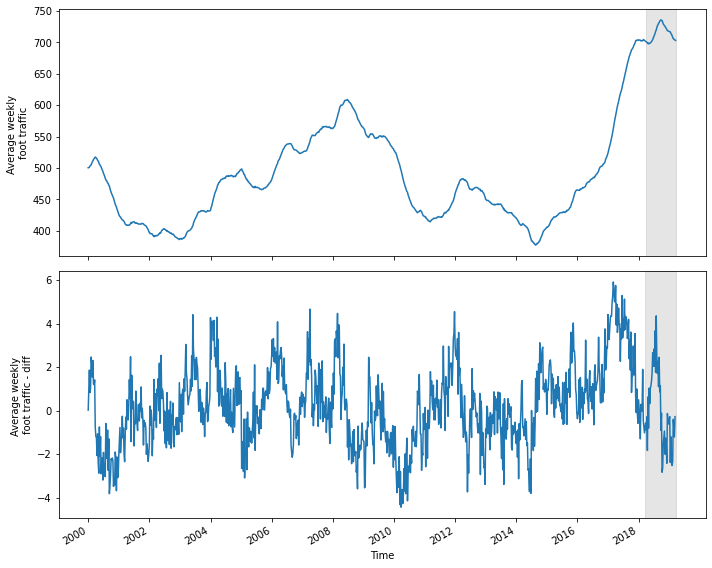

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(df['foot_traffic'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Average weekly \nfoot traffic')
ax1.axvspan(948, 1000, color='#808080', alpha=0.2)

ax2.plot(df_diff)
ax2.set_xlabel('Time')
ax2.set_ylabel('Average weekly \nfoot traffic - diff')

ax2.axvspan(947, 999, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()

plt.tight_layout()

In [10]:
# use optimize_ARIMA function to fit the many ARIMA(p,d,q) models

from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    results = []

    # Iterate over each unique (p,q) combination. The use of tqdm_notebook will display a progress bar
    for order in tqdm(order_list):
        try:
            # Fit an ARIMA(p,d,q) model using the SARIMAX function.
            # We specify simple_differencing=False, to prevent differencing.
            # We also specify disp=False to avoid printing convergence messages to the console
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])
    
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,d,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [11]:
# We define a list of possible values for the orders p and q.

from itertools import product

ps = range(0, 4, 1)
qs = range(0, 4, 1)
order_list = list(product(ps, qs))

In [12]:
# Run the optimize_ARIMA function to obtain the model with the lowest AIC.
import warnings
warnings.filterwarnings('ignore')

result_df = optimize_ARIMA(train, order_list, d)
result_df

,"(p,d,q)",AIC
0,"(1, 3)",2661.641634
1,"(3, 1)",2662.229345
2,"(3, 0)",2662.347811
3,"(2, 1)",2663.531853
4,"(3, 2)",2663.543837
5,"(2, 3)",2663.604432
6,"(3, 3)",2664.417656
7,"(2, 2)",2664.894714
8,"(2, 0)",2671.404843
9,"(1, 2)",2673.447547


In [13]:
# From the returned DataFrame, an ARIMA(1,1,3) model seems to be the most suitable, so fit it on the training set
# The expected ARIMA(3, 1, 0) model was third.

model = SARIMAX(train, order=(1,1,3), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           foot_traffic   No. Observations:                  950
Model:               SARIMAX(1, 1, 3)   Log Likelihood               -1325.821
Date:                Wed, 27 Sep 2023   AIC                           2661.642
Time:                        12:19:55   BIC                           2685.919
Sample:                             0   HQIC                          2670.892
                                - 950                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9528      0.013     75.651      0.000       0.928       0.978
ma.L1         -0.6317      0.036    -17.772      0.000      -0.701      -0.562
ma.L2          0.2909      0.039      7.491      0.0

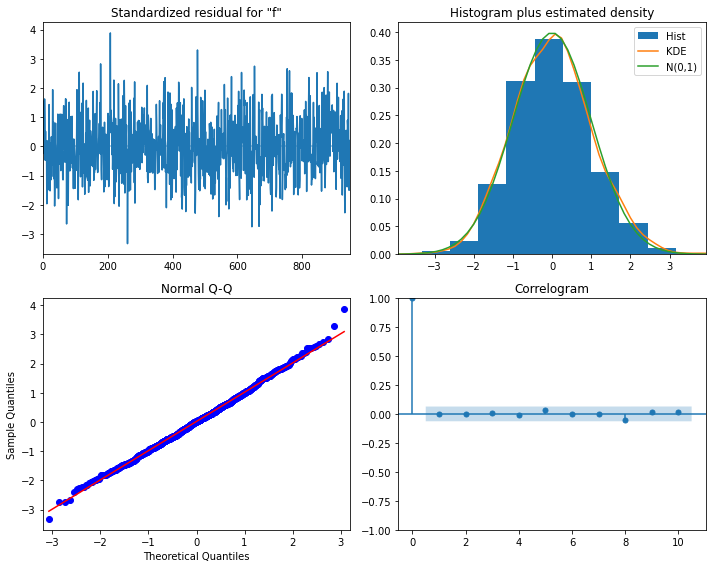

In [14]:
model_fit.plot_diagnostics(figsize=(10,8))

plt.tight_layout()

In [15]:
# From the the top-left plot, the variance is not constant, which is a discrepancy in comparison to white noise. 
# At the top right is the distribution of the residuals, we can see that it is close to a normal distribution. 
# The Q-Q plot displays a line that is fairly straight, so the residuals’ distribution is close to a normal distribution. 
# Finally, the correlogram at the bottom right, shows no significant coefficients after lag 0, just like white noise.

# Thus, from a qualitative standpoint, it seems that our residuals are close to white noise, which is a good sign, 
# as it means that the model’s errors are random.

In [16]:
# Finally apply the Ljung-Box test to quantitatively assess whether our residuals are indeed uncorrelated.
from statsmodels.stats.diagnostic import acorr_ljungbox

lbvalue = acorr_ljungbox(residuals, np.arange(1,11,1), return_df=True) 
lbvalue.columns=['stat', 'p-value']
lbvalue

,stat,p-value
1,1.424403e-07,0.999699
2,2.820468e-03,0.998591
3,1.149215e-02,0.999673
4,1.171852e-02,0.999983
5,1.188295e-02,0.999999
6,2.126975e-02,1.000000
7,2.387884e-02,1.000000
8,2.514250e-02,1.000000
9,2.617624e-02,1.000000
10,2.678076e-02,1.000000


In [17]:
# p-values are all greater than 0.05, so the residuals are NOT correlated just like white noise.
# As a benchmark for our model, we use the mean, last value & MA. 

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
    
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean
    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    elif method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(1,1,3))
            
            res = model.fit(disp=False)
            
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)
        return pred_ARIMA

In [19]:
test = pd.DataFrame(test)
test.columns = ['foot_traffic']
test.head()

,foot_traffic
950,700.221501
951,699.937948
952,698.107264
953,698.742777
954,697.935155


In [20]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_ARIMA'] = pred_ARIMA

test.head()

,foot_traffic,pred_mean,pred_last_value,pred_ARIMA
950,700.221501,481.668474,701.112198,700.547566
951,699.937948,481.668474,701.112198,700.062570
952,698.107264,482.127321,699.937948,699.353089
953,698.742777,482.127321,699.937948,698.928865
954,697.935155,482.580775,698.742777,698.018311


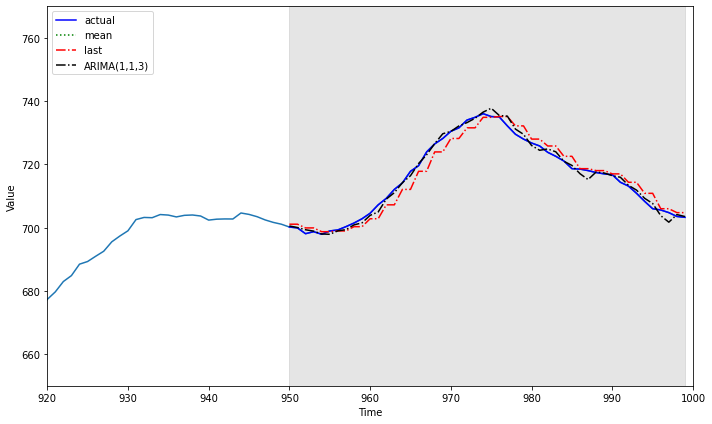

In [21]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(df['foot_traffic'])
ax.plot(test['foot_traffic'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARIMA'], 'k-.', label='ARIMA(1,1,3)')
ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Value')

ax.axvspan(950, 999, color='#808080', alpha=0.2)

ax.set_xlim(920, 1000)  #Zoom in on the testing period
ax.set_ylim(650, 770)

fig.autofmt_xdate
plt.tight_layout()

In [22]:
# Quantify error using the mean Absolute Error (MAE)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred)) 

In [23]:
mae_mean = mae(test['foot_traffic'], test['pred_mean'])
mae_last = mae(test['foot_traffic'], test['pred_last_value'])
mae_ARIMA = mae(test['foot_traffic'], test['pred_ARIMA'])

print(mae_mean, mae_last, mae_ARIMA)

228.3662525747094 2.1101063474061514 0.9676771462803799


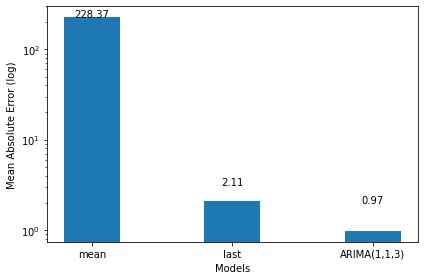

In [24]:
fig, ax = plt.subplots()

x = ['mean', 'last', 'ARIMA(1,1,3)']
y = [mae_mean, mae_last, mae_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('Mean Absolute Error (log)')
plt.yscale('log')

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

In [25]:
# ARIMA(1,1,3) has a better(lower) Mean Absolute Error than AR(3.48) for the same foot_traffic dataset

In [26]:
# record end time

end = dt.now()
elapsed = end-start
print("The program took: %02d:%02d:%02d:%02d" % (elapsed.days, elapsed.seconds // 3600, elapsed.seconds // 60 % 60, elapsed.seconds % 60))

The program took: 00:00:01:24
